In [1]:
from  isotools import Transcriptome
import isotools
print (f'This is isotools version {isotools.__version__}')
from isotools.plots import plot_bar, plot_distr, plot_saturation, plot_rarefaction


import os
import pandas as pd
import numpy as np
from glob import glob
import matplotlib.pyplot as plt
import logging
import pathlib

logging.basicConfig(format='%(levelname)s:%(message)s', level=logging.INFO)


This is isotools version 0.3.3rc6


In [2]:
path='/project/42/pacbio/golong'
date='2022_12'
project='golong_all'
out_path=f'{path}/06-isotools/{project}/results_{date}'
plot_path=f'{out_path}/02_QC/plots'
table_path=f'{out_path}/02_QC/tables'
pathlib.Path(plot_path).mkdir(parents=True, exist_ok=True)
pathlib.Path(table_path).mkdir(parents=True, exist_ok=True)

ref_fn=f'{path}/../references/gencode/gencode.v36.chr_patch_hapl_scaff.annotation_sorted'
genome_fn=f'{path}/../references/gencode/GRCh38.p13.genome.fa'

In [3]:
# set plot parameters
plt.rcParams['axes.unicode_minus']=False
plt.rcParams["font.size"]=8
plt.rcParams["font.family"]='sans-serif'#"Times New Roman"
plt.rcParams['figure.dpi']=200


## Load isoseq data

In [16]:

isoseq=Transcriptome.load(f'{out_path}/01_transcriptome/golong_all_{date}_isotools_sparse.pkl')


INFO:loading transcriptome from /project/42/pacbio/golong/06-isotools/golong_all/results_2022_12/01_transcriptome/golong_all_2022_12_isotools_sparse.pkl


In [8]:
tr_tab=pd.read_csv(f'{out_path}/01_transcriptome/{project}_{date}_substantial_transcripts.csv.gz', sep='\t')

In [17]:
# define group and sample colors

groups={k:v for k,v in isoseq.groups().items() if k[:3] in ['CLL', 'MDS']}

group_dict={sa:gn for gn,sa_list in isoseq.groups().items() for sa in sa_list}
group_num={sa:i for i,sa in enumerate(['K562_mut','K562_wt','Nalm6_mut', 'Nalm6_wt','CLL_mut','CLL_wt', 'MDS_mut', 'MDS_wt','B-cell'])}

groups['CL_wt']=[sa for gr in ['K562_wt', 'Nalm6_wt'] for sa in isoseq.groups()[gr]]
groups['CL_mut']=[sa for gr in ['K562_mut', 'Nalm6_mut'] for sa in isoseq.groups()[gr]]
groups['B-cell']=isoseq.groups()['B-cell']
#groups['GM12878_ENCODE']=isoseq.groups()['GM12878']
group_colors={'CLL_mut':'#B2182B', 'CLL_wt':'#2166AC', 'MDS_mut':'#EF8A62', 'MDS_wt':'#67A9CF','CL_mut':'#FDDBC7' ,'CL_wt':'#D1E5F0','B-cell':'#543005','other':'#018571'}
group_colors['all_mut']=group_colors['MDS_mut']
group_colors['all_wt']=group_colors['MDS_wt']
group_colors['reference']=group_colors['other']

sample_colors={sa:group_colors[k] for sa in isoseq.samples for k,v in groups.items() if sa in v }
sample_colors={sa:sample_colors.get(sa,'#003C30') for sa in isoseq.samples}
sample_colors['reference']=group_colors['other']

groups_CL={k:v for k,v in groups.items() if k[:3] in ['CL_', 'GM1']}
groups_CLL={k:v for k,v in groups.items() if k in ['CLL_wt', 'CLL_mut', 'B-cell']}
groups_MDS={k:v for k,v in groups.items() if k in ['MDS_wt', 'MDS_mut', 'B-cell']}

group_same_colors={k:group_colors["all_"+k.split("_")[1]] for k in group_colors if 'wt' in k or 'mut' in k}
group_same_colors['B-cell']=group_colors['B-cell']


## Saturation

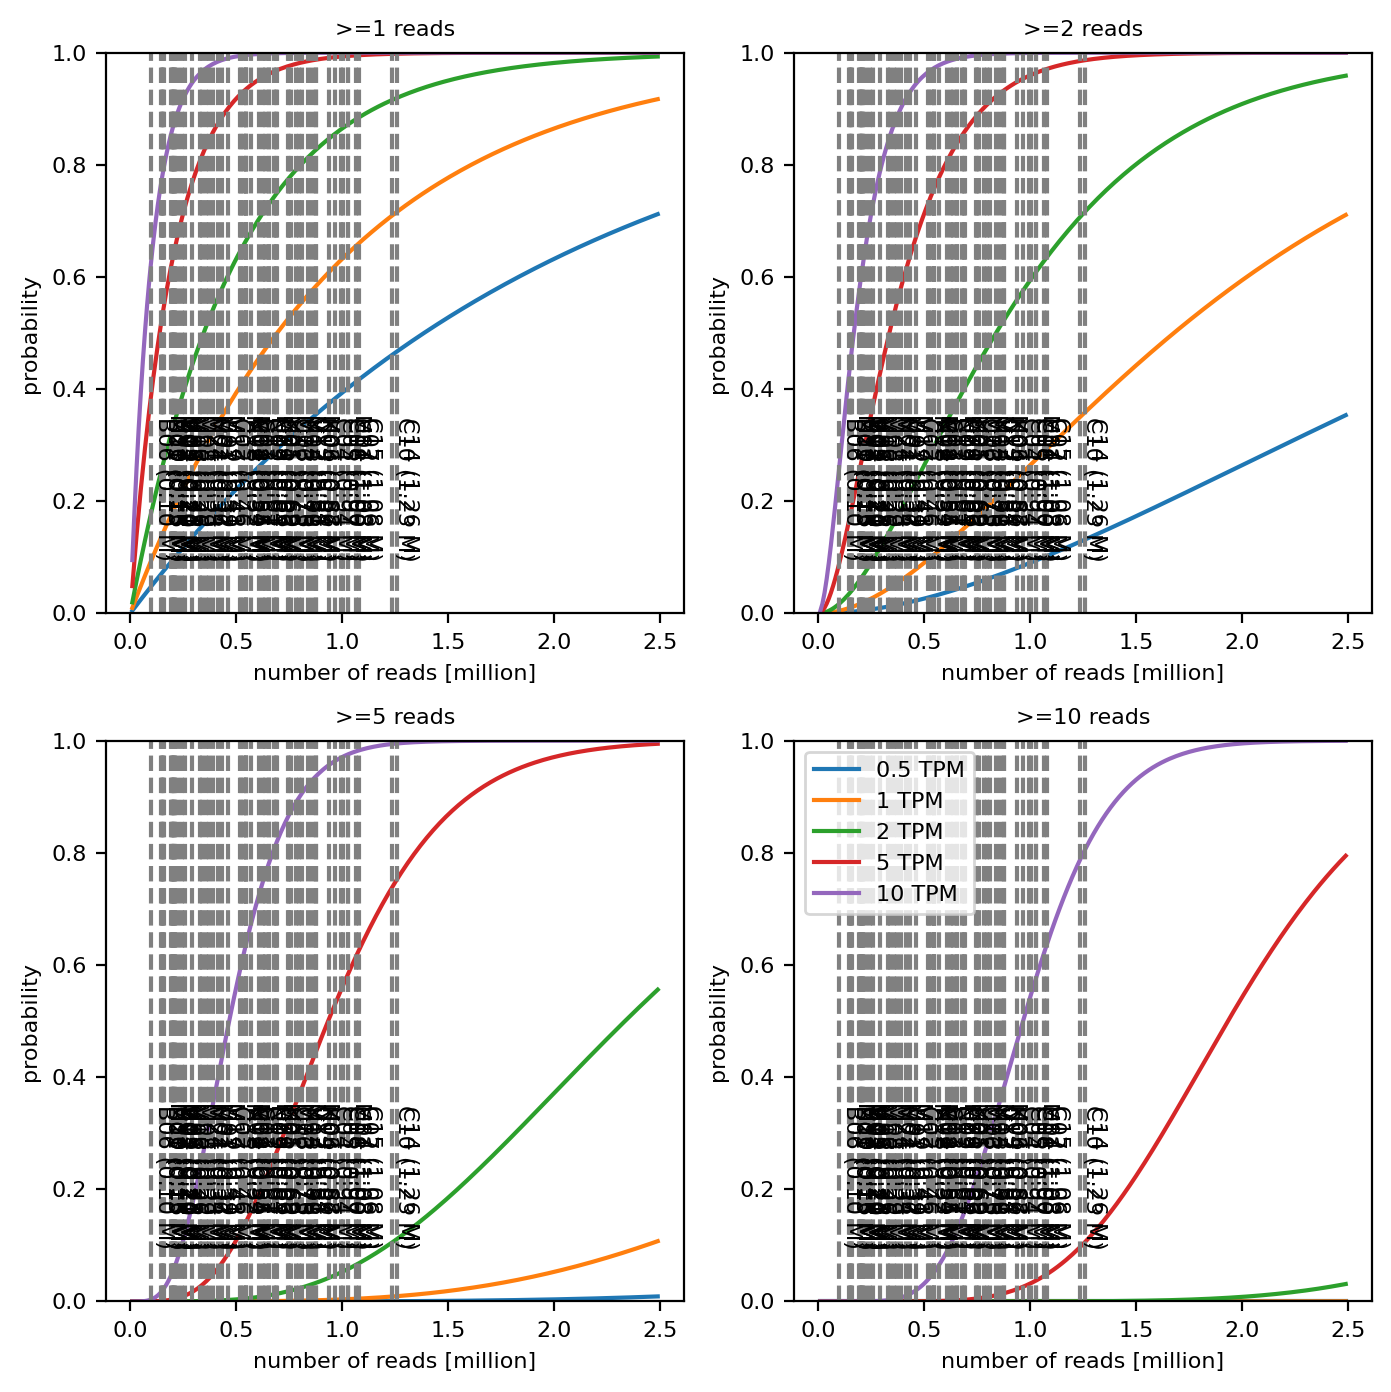

In [6]:
plt.rcParams["figure.figsize"] = (7,7)

f,axs=plt.subplots(2,2)
for nr,(ax,cov_th) in enumerate(zip(axs.flatten(),[1,2,5,10])):
    plot_saturation(isoseq, ax=ax,cov_th=cov_th, title='',x_range=(1e4,2.5e6,1e4), legend=False, xlabel='number of reads [million]', ylabel='probability')
    ax.set_title(f'>={cov_th} reads',{'fontsize':8})
ax.legend(loc='upper left')
f.tight_layout()
f.savefig(f'{plot_path}/{project}_{date}_saturation.pdf') 

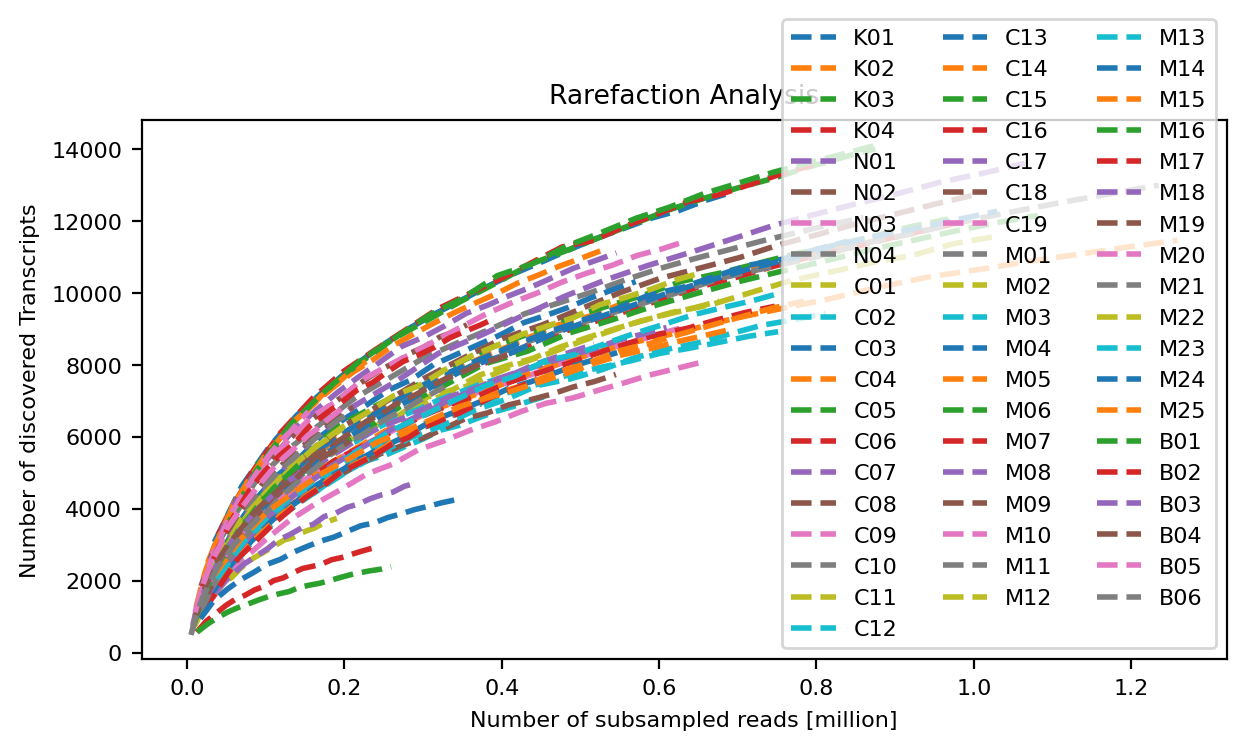

In [7]:
plt.rcParams["figure.figsize"] = (7,3.5)

rarefraction, total=isoseq.rarefaction(min_coverage=2, tr_filter={'query':'FSM'})
f,ax=plt.subplots()
plot_rarefaction(rarefraction, total=total, legend=False, ax=ax, lw=2, ls='dashed') #just to test the new options
ax.legend(loc='lower right', ncol=3)
f.savefig(f'{plot_path}/{project}_{date}_rarefraction.pdf') 

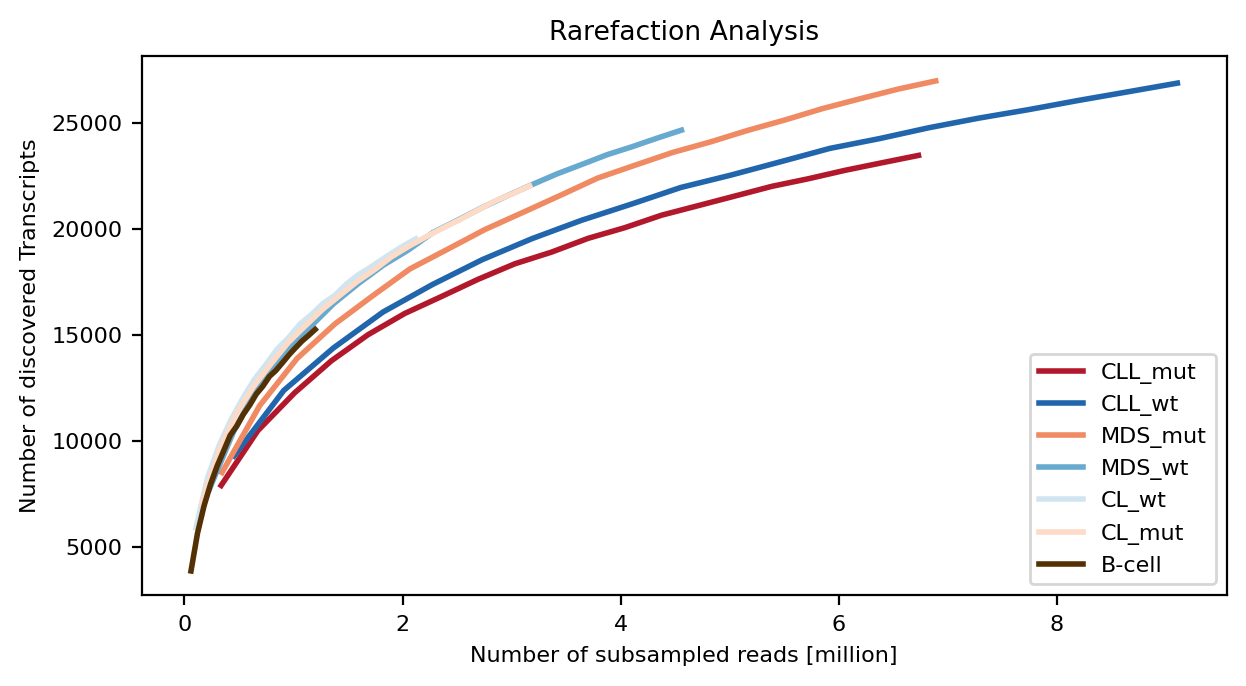

In [8]:
plt.rcParams["figure.figsize"] = (7,3.5)
rarefraction_grp, total_grp=isoseq.rarefaction(min_coverage=2, tr_filter={'query':'FSM'}, groups=groups)
f,ax=plt.subplots()
plot_rarefaction(rarefraction_grp, total=total_grp, legend=True, ax=ax, colors=group_colors, lw=2)
f.savefig(f'{plot_path}/{project}_{date}_rarefraction_grp.pdf') 

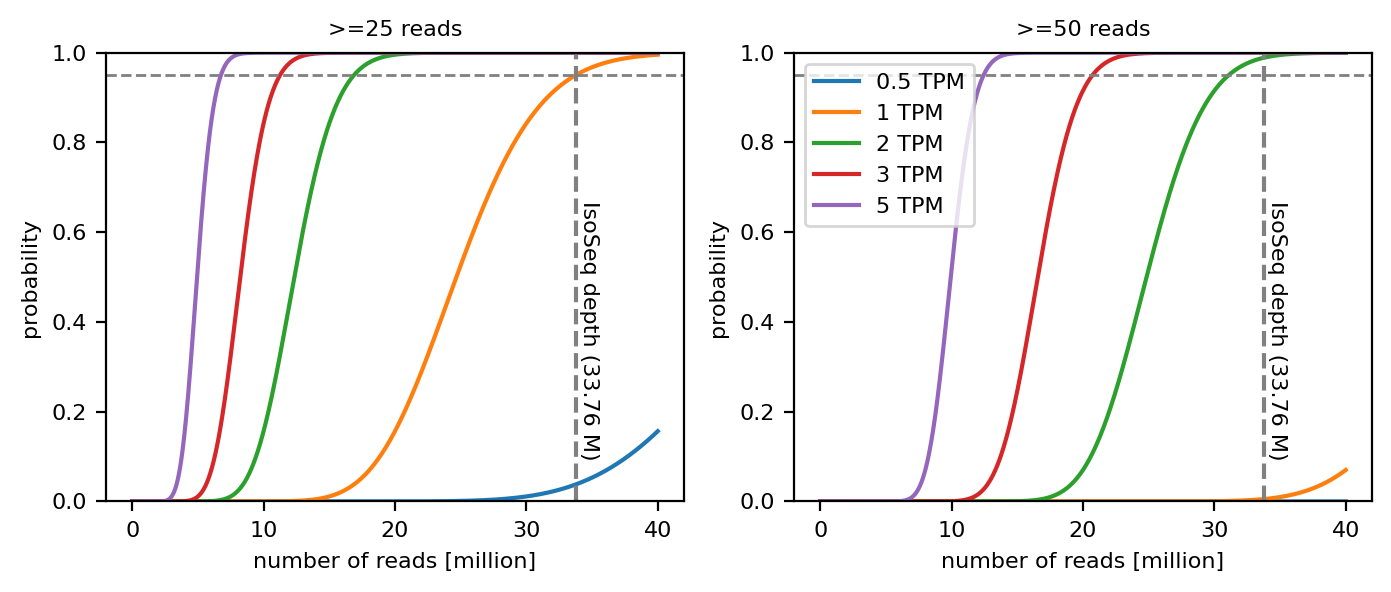

In [28]:

f,axs=plt.subplots(1,2, figsize=(7,3))
sat_res=[]
cov=isoseq.sample_table.nonchimeric_reads.sum()
k=1e4,40e6
sa='IsoSeq depth'
for nr,(ax,cov_th) in enumerate(zip(axs.flatten(),[25,50])):
    res_i=plot_saturation( ax=ax,cov_th=cov_th, title='',x_range=(*k,1e4),  expr_th=[0.5, 1, 2, 3, 5],legend=False, xlabel='number of reads [million]', ylabel='probability')
    sat_res.append(res_i)
    ax.set_title(f'>={cov_th} reads',{'fontsize':8})
    ax.axvline(cov / 1e6, color='grey', ls='--')
    ax.axhline(.95, color='grey', ls='--', lw=1)

    ax.text((cov + (k[-1] - k[0]) / 200) / 1e6, 0.1, f'{sa} ({cov/1e6:.2f} M)', rotation=-90)
ax.legend(loc='upper left')
f.tight_layout()
f.savefig(f'{plot_path}/{project}_{date}_saturation_total.pdf') 




In [29]:
from scipy.stats import beta, nbinom
cov_th=25
tpm_th=1
p_1=nbinom.cdf(isoseq.sample_table.nonchimeric_reads.sum() - cov_th, n=cov_th, p=tpm_th * 1e-6)
cov_th=50
tpm_th=2
p_2=nbinom.cdf(isoseq.sample_table.nonchimeric_reads.sum() - cov_th, n=cov_th, p=tpm_th * 1e-6)
print(f'{p_1:.2%} of the 1 TPM transcripts are discovered with > 25 reads')
print(f'{p_2:.2%} of the 2 TPM transcripts are discovered with > 50 reads')

95.02% of the 1 TPM transcripts are discovered with > 25 reads
98.88% of the 2 TPM transcripts are discovered with > 50 reads


## Biases and Filtering

In [9]:

isoseq.add_filter( "HIGH_SUPPORT", 'transcript_support_level=="1"', context='reference')
isoseq.add_filter( "PROTEIN_CODING", 'reference and reference["gene_type"]=="protein_coding"', context='gene')
isoseq.add_filter( "NMD", 'ORF and ORF[2]["NMD"]', context='transcript')
isoseq.add_filter( "CODING_ORF", 'ORF  and not ORF[2]["NMD"] and ORF[2]["length"] > 200', context='transcript')


In [10]:

nmd_stats_sample=isoseq.filter_stats( weight_by_coverage=True,min_coverage=1,tr_filter={"query":"PROTEIN_CODING and not (RTTS or INTERNAL_PRIMING or FRAGMENT)",'progress_bar':True}, tags=['NMD','CODING_ORF'])
nmd_stats_sample=(nmd_stats_sample[0][sorted(nmd_stats_sample[0].columns, key=lambda x:group_num[group_dict[x]])], nmd_stats_sample[1])
nmd_stats_sample[0].to_csv(f'{table_path}/{project}_{date}_NMD_stats.csv')

100%|██████████| 149009/149009 [00:43<00:00, 3401.44genes/s]


In [ ]:
# average read length all samples
len_sum, w_sum=0,0
for g,trid, tr in isoseq.iter_transcripts(progress_bar=True):
    l=sum(e[1]-e[0] for e in tr['exons'])
    w=sum(g.coverage[:,trid])
    len_sum+=w*l
    w_sum+=w
len_sum/w_sum
#2720.738812798533

In [ ]:
# average read length per sample
len_sum, w_sum=np.zeros(len(isoseq.samples)),np.zeros(len(isoseq.samples))
for g,trid, tr in isoseq.iter_transcripts(progress_bar=True):
    l=sum(e[1]-e[0] for e in tr['exons'])
    w=g.coverage[:,trid]
    len_sum+=w*l
    w_sum+=w
for sa, avg in zip(isoseq.samples, len_sum/w_sum):
    print(f'{sa}: {avg:.1f}')
    

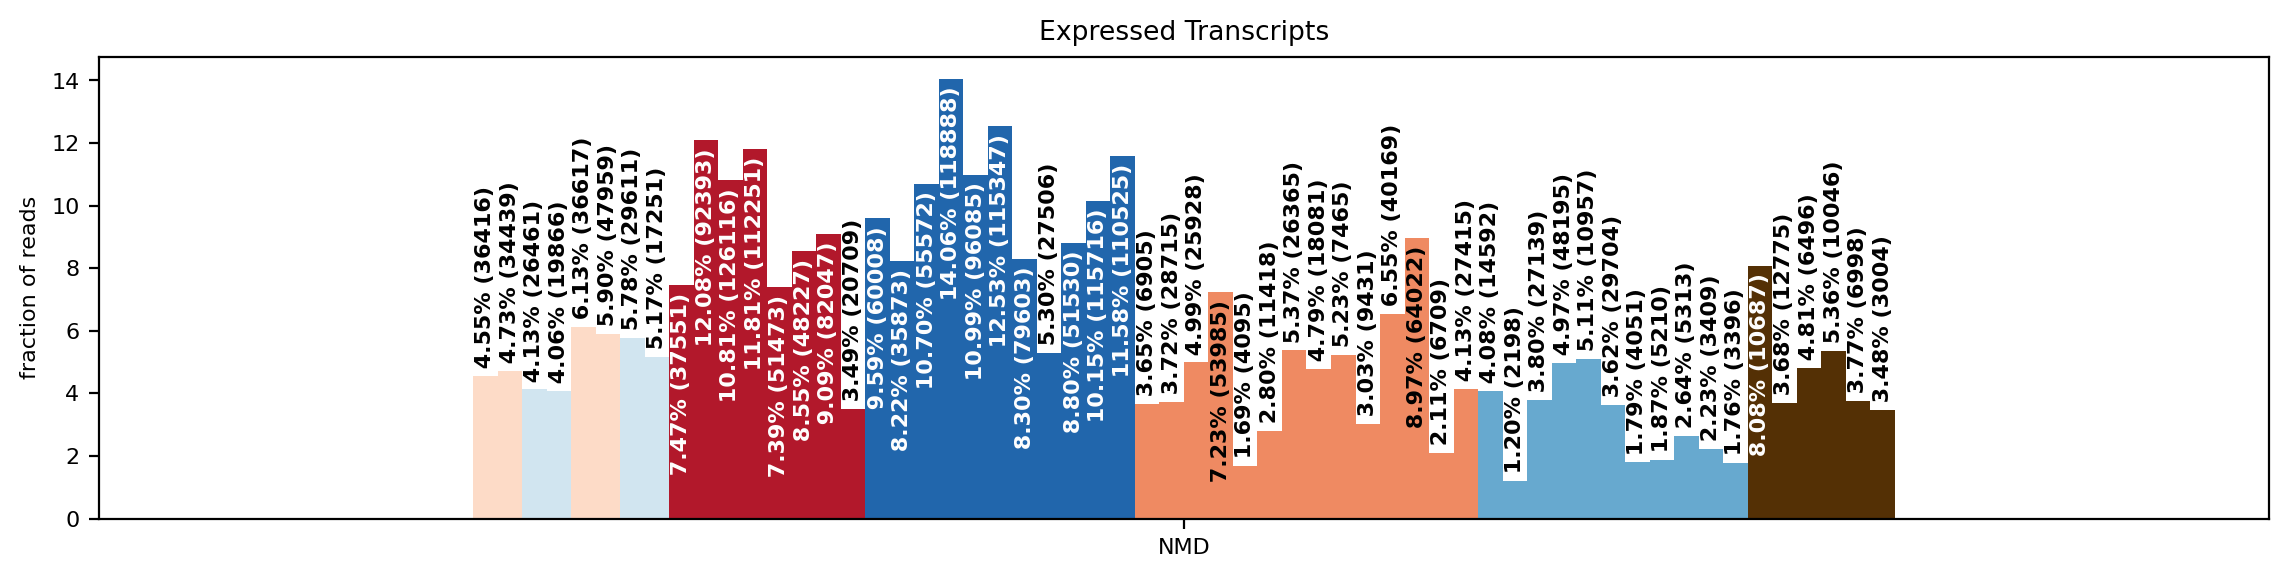

In [11]:
plt.rcParams["figure.figsize"] = (14,3)

plot_bar(nmd_stats_sample[0].loc[['total','NMD']],legend=False,rot=0, bar_width=.95,colors=sample_colors,**nmd_stats_sample[1])
plt.savefig(f"{plot_path}/{project}_{date}_NMD_stats.pdf")
#todo: add sample names

In [12]:
tr_len=isoseq.transcript_length_hist(add_reference=True,tr_filter=dict(progress_bar=True),  ref_filter=dict(query='HIGH_SUPPORT', progress_bar=True))

100%|██████████| 149009/149009 [00:01<00:00, 94370.59genes/s]


/scratch/local/ipykernel_71562/1568630137.py:9: UserWarning: Tight layout not applied. tight_layout cannot make axes width small enough to accommodate all axes decorations
  plt.tight_layout()


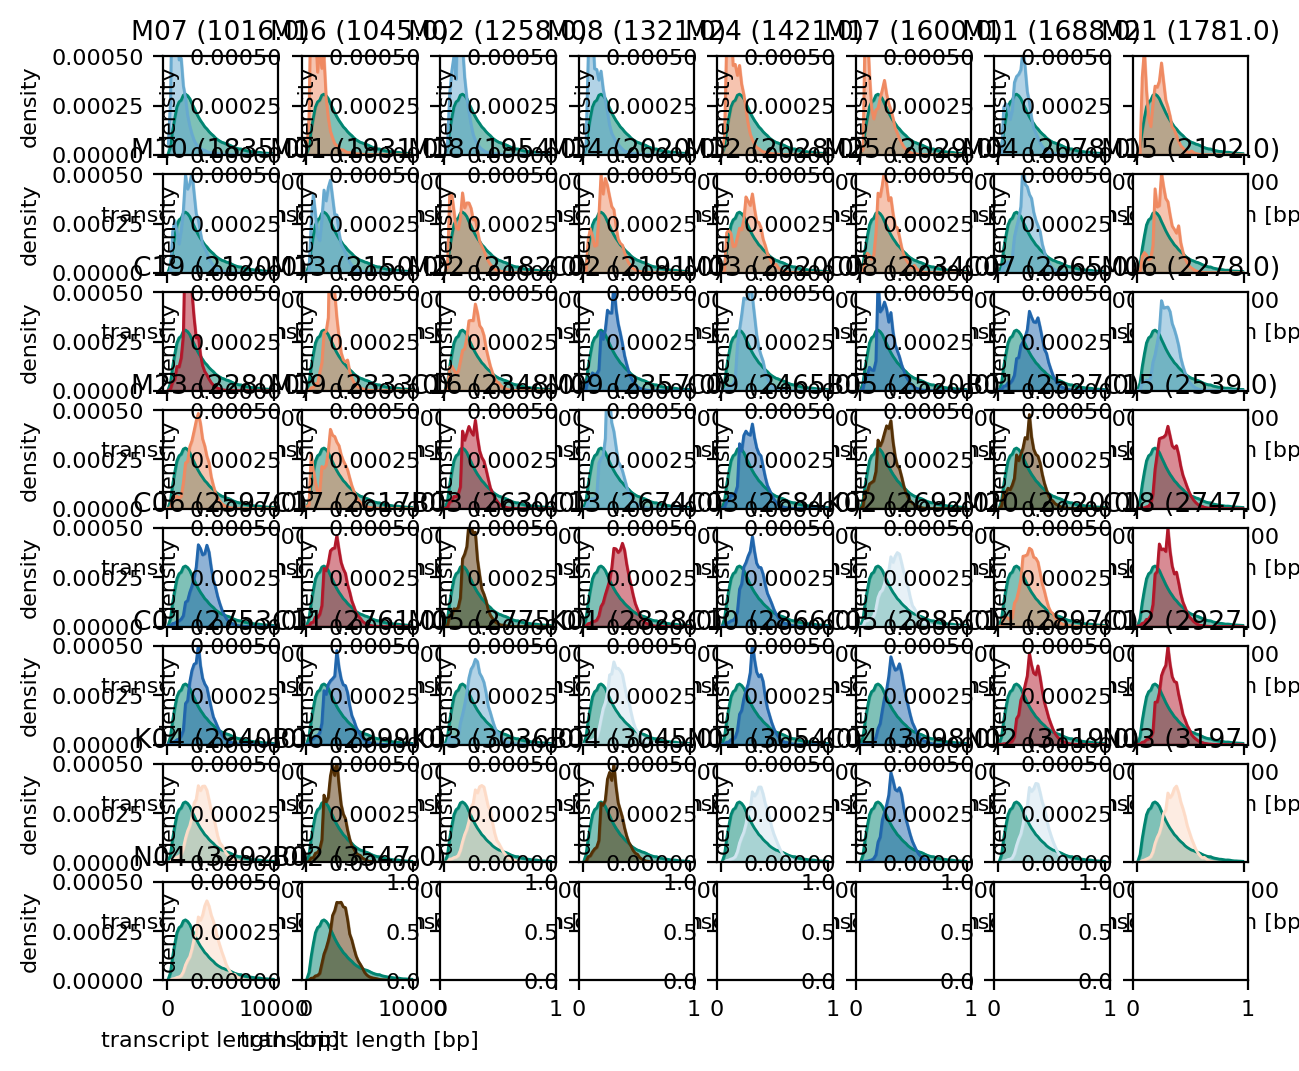

In [13]:
plt.rcParams["figure.figsize"] = (7,6)
f, axs = plt.subplots(8,8)
cov=dict(isoseq.sample_table.set_index('name').DNA_smear)
for (sa,n_reads),ax in zip(sorted(cov.items(), key=lambda x:x[1]), axs.flatten()):    
    tr_len[1]['title']=f'{sa} ({n_reads})'
    plot_distr(tr_len[0][['reference',sa]],smooth=3,legend=False,ax=ax,colors=sample_colors, **tr_len[1])
    ax.set_ylim(0,5e-4)
    ax.ticklabel_format(axis='y', style='sci')
plt.tight_layout()
plt.savefig(f'{plot_path}/{project}_{date}_DNA_smear.pdf')
#todo: remove y labesl? to make more space for the plots? increase size, remove 


In [30]:
tr_stats=[
    isoseq.transcript_length_hist(groups=groups, add_reference=True, min_coverage=2,tr_filter=dict( query='not NOVEL_GENE', progress_bar=True), ref_filter=dict(query='HIGH_SUPPORT', progress_bar=True)),
    isoseq.downstream_a_hist(groups=groups, tr_filter=dict( query='not (NOVEL_GENE or UNSPLICED)', progress_bar=True), ref_filter=dict(query='not UNSPLICED', progress_bar=True)),
    isoseq.downstream_a_hist(groups=groups, tr_filter=dict(query='NOVEL_GENE and UNSPLICED', progress_bar=True))]
for _,par in tr_stats:
    del par['title']
tr_stats.append((pd.concat([tr_stats[2][0].add_suffix(' novel unspliced'),tr_stats[1][0].add_suffix(' known multiexon')],axis=1),tr_stats[2][1]))
#tr_stats[0]=(tr_stats[0][0][tr_stats[0][0].columns[[2,0,1]]],tr_stats[0][1])     
#tr_stats[3]=(tr_stats[3][0][tr_stats[3][0].columns[[2,0,3,1]]],tr_stats[3][1])     
#tr_stats[4]=(tr_stats[4][0][tr_stats[4][0].columns[[2,0,3,1]]],tr_stats[4][1])

100%|██████████| 149009/149009 [00:12<00:00, 11739.75genes/s]


AssertionError: did not find the following filter rules: HIGH_SUPPORT
valid rules are: REF_UNSPLICED, REF_MULTIEXON, REF_INTERNAL_PRIMING, NOVEL_GENE, EXPRESSED, CHIMERIC

In [ ]:
f_stats=isoseq.filter_stats( groups=groups, weight_by_coverage=True,min_coverage=1,tr_filter={'progress_bar':True}, tags=['RTTS', 'INTERNAL_PRIMING','FRAGMENT'])
f_stats[0].index=f_stats[0].index.str.replace('_','\n')
del f_stats[1]['title']
f=sum(np.array([g.coverage[:,trid] for g,trid,tr in isoseq.iter_transcripts(query='RTTS or INTERNAL_PRIMING or FRAGMENT')]))
total=sum(np.array([g.coverage[:,trid] for g,trid,tr in isoseq.iter_transcripts()]))
print(f'{f/total*100} percent filtered ({f} reads)')

In [ ]:
#figure3: QC plot
plt.rcParams["figure.figsize"] = (7,5)

fig, axs = plt.subplots(2,2)
#A) transcript length
plot_distr(tr_stats[0][0],smooth=5,ax=axs[0,0],**tr_stats[0][1], fill=False, colors=group_colors, lw=2, legend=False)  
#B) frequency of artifacts
plot_bar(f_stats[0].loc[['total','RTTS', 'FRAGMENT', 'INTERNAL\nPRIMING']],ax=axs[0,1],**f_stats[1], legend=False, colors=group_colors)
axs[0,0].legend(loc='upper right', ncol=1)
# internal priming
# plot_distr(tr_stats[4][0][[c for c in tr_stats[4][0].columns if 'novel' in c]],smooth=3,ax=axs[1,0],density=True,fill=True, **tr_stats[4][1])  
# plot_distr(tr_stats[4][0][[c for c in tr_stats[4][0].columns if 'known' in c]],smooth=3,ax=axs[1,1],density=True,fill=True, **tr_stats[4][1])  
#C/D) RTTS
#plot_distr(tr_stats[3][0][[c for c in tr_stats[3][0].columns if 'known' in c]],ax=axs[1,0],density=True,**tr_stats[3][1],fill=False,smooth=5,colors={f'{k} known multiexon':v for k,v in group_colors.items()})

#plot_distr(tr_stats[3][0][[c for c in tr_stats[3][0].columns if 'novel' in c]],ax=axs[1,1],density=True,**tr_stats[3][1],fill=False,smooth=5,colors={f'{k} novel unspliced':v for k,v in group_colors.items()})

plot_distr(tr_stats[1][0],ax=axs[1,0],density=True,**tr_stats[1][1],fill=False,smooth=5,colors=group_colors, lw=2, legend=False)
plot_distr(tr_stats[2][0],ax=axs[1,1],density=True,**tr_stats[2][1],fill=False,smooth=5,colors=group_colors, lw=2, legend=False)

for letter,ax in zip('ABCD',axs.flatten()):
    ax.set_title(letter,{'fontsize':8}, loc='left', pad=20)

plt.tight_layout()
plt.savefig(f'{plot_path}/{project}_{date}_qc_metrics.pdf')

In [17]:
f_stats_sample=isoseq.filter_stats( weight_by_coverage=True,min_coverage=1,tr_filter={'progress_bar':True}, tags=['RTTS', 'INTERNAL_PRIMING','FRAGMENT'])


100%|██████████| 149009/149009 [00:32<00:00, 4616.94genes/s]


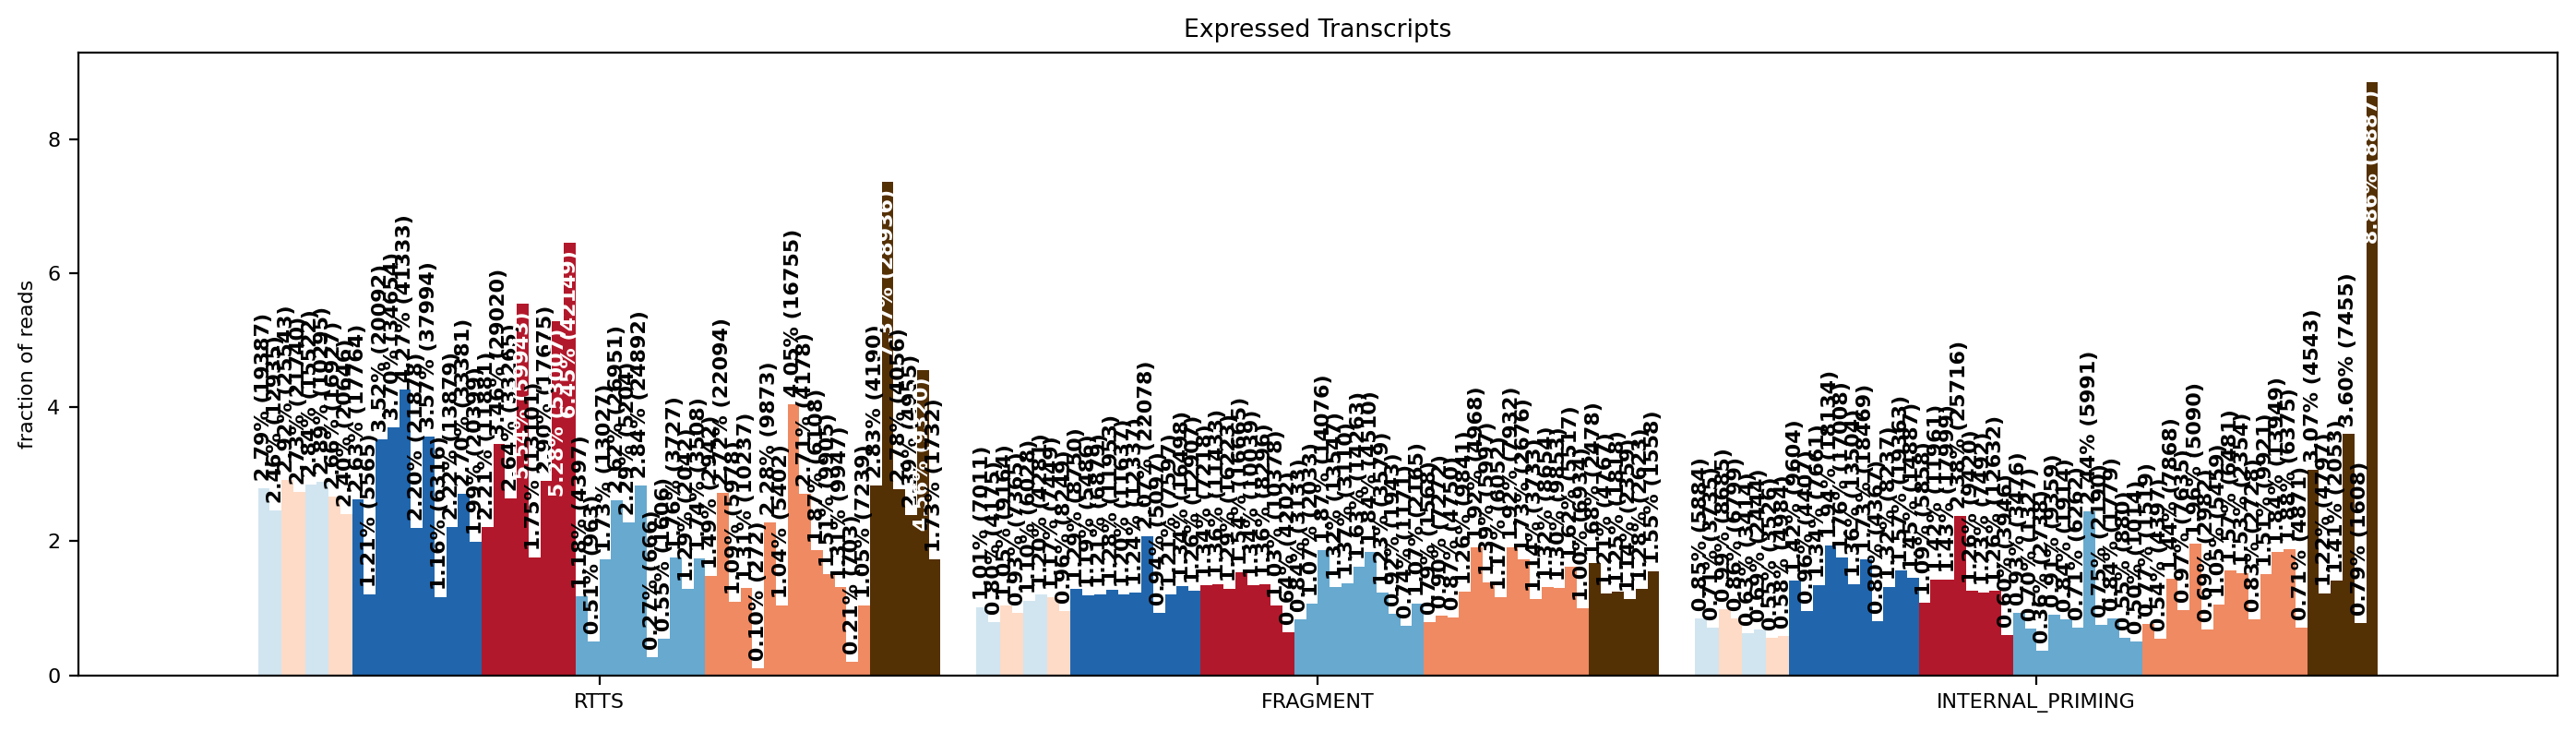

In [18]:
plt.rcParams["figure.figsize"] = (14,4)
plot_bar(f_stats_sample[0].loc[['total','RTTS', 'FRAGMENT', 'INTERNAL_PRIMING']],legend=False,rot=0, bar_width=.95,colors=sample_colors, **f_stats_sample[1])
#plt.legend(fontsize='medium', ncol=13,handleheight=.4, labelspacing=0.01)
plt.tight_layout()
plt.savefig(f'{plot_path}/{project}_{date}_qc_metrics_samples.pdf')

# alternative splicing classification

In [19]:
# explain refined sqanti 
# barplot (zu figure 3?)
cname=['FSM','ISM','NIC','NNC','novel gene']
cnr={}
for g, trid, tr in isoseq.iter_transcripts():
    for anno in tr['annotation'][1]:
        cnr[anno]=min(cnr.get(anno,5),tr['annotation'][0])
del cnr['FSM']
altsplice=[ isoseq.altsplice_stats(groups=groups, weight_by_coverage=True, min_coverage=1, tr_filter=dict( query='FSM or not (RTTS or INTERNAL_PRIMING or FRAGMENT)', progress_bar=True))
           # isoseq.altsplice_stats(groups=groups, weight_by_coverage=True, min_coverage=2, tr_filter=dict( query='(RTTS or INTERNAL_PRIMING or FRAGMENT)', progress_bar=True)),
           # isoseq.altsplice_stats(groups=groups, weight_by_coverage=False, min_coverage=20, tr_filter=dict( query='CODING_ORF and SUBSTANTIAL and not (RTTS or INTERNAL_PRIMING or FRAGMENT)', progress_bar=True))]
          ]
for i in range(len(altsplice)):
    altsplice[i][0].index=altsplice[i][0].index+[f'\n({cname[cnr[subcat]]})' if subcat in cnr else '' for subcat in altsplice[i][0].index]
    altsplice[i][0].index=altsplice[i][0].index.str.replace('splice ','\nsplice ')

100%|██████████| 149009/149009 [00:52<00:00, 2854.31genes/s]


In [20]:
altsplice_sample= isoseq.altsplice_stats( weight_by_coverage=True, min_coverage=1, tr_filter=dict( query='FSM or not (RTTS or FRAGMENT or INTERNAL_PRIMING)',progress_bar=True ))
altsplice_sample[0].index=altsplice_sample[0].index+[f'\n({cname[cnr[subcat]]})' if subcat in cnr else '' for subcat in altsplice_sample[0].index]


100%|██████████| 149009/149009 [00:47<00:00, 3130.87genes/s]


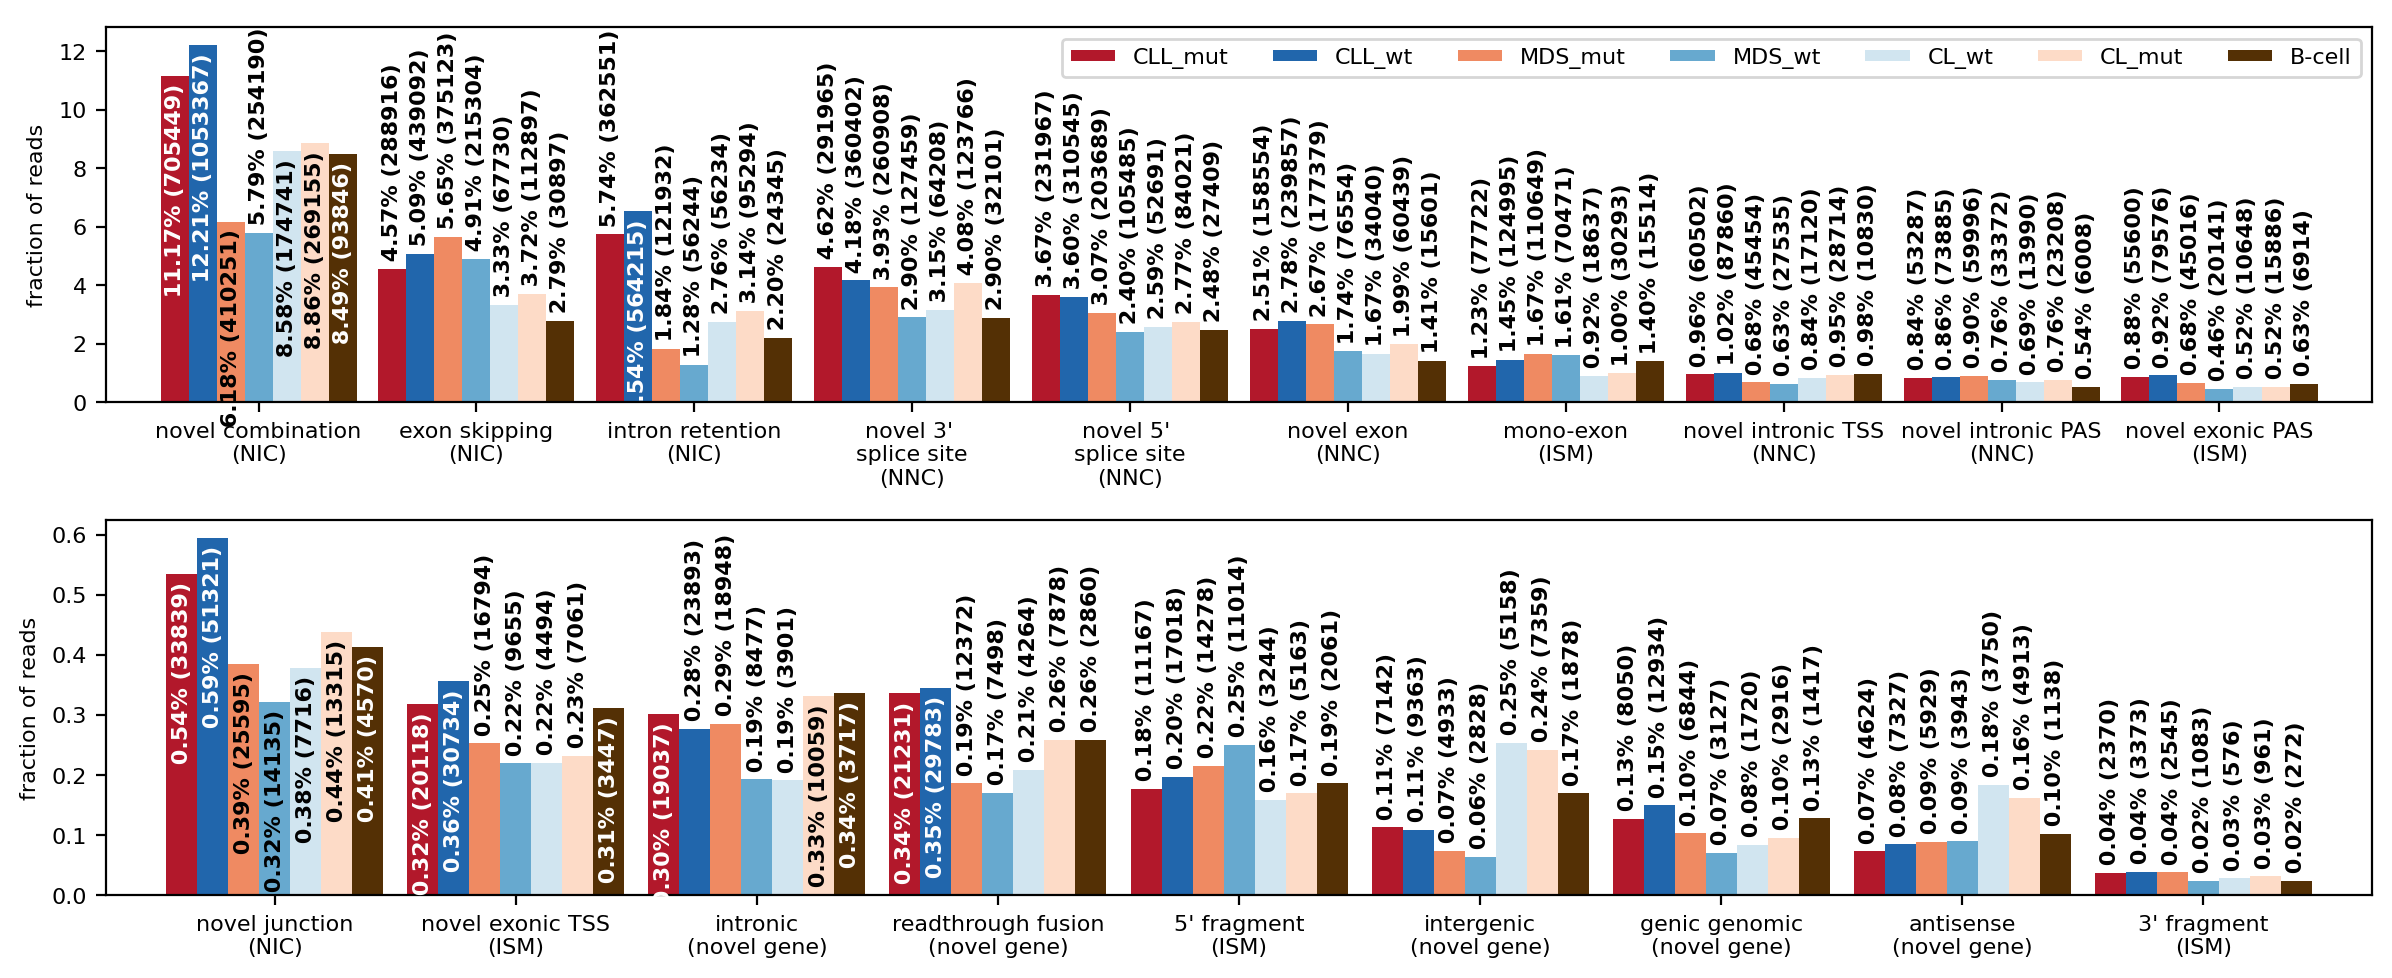

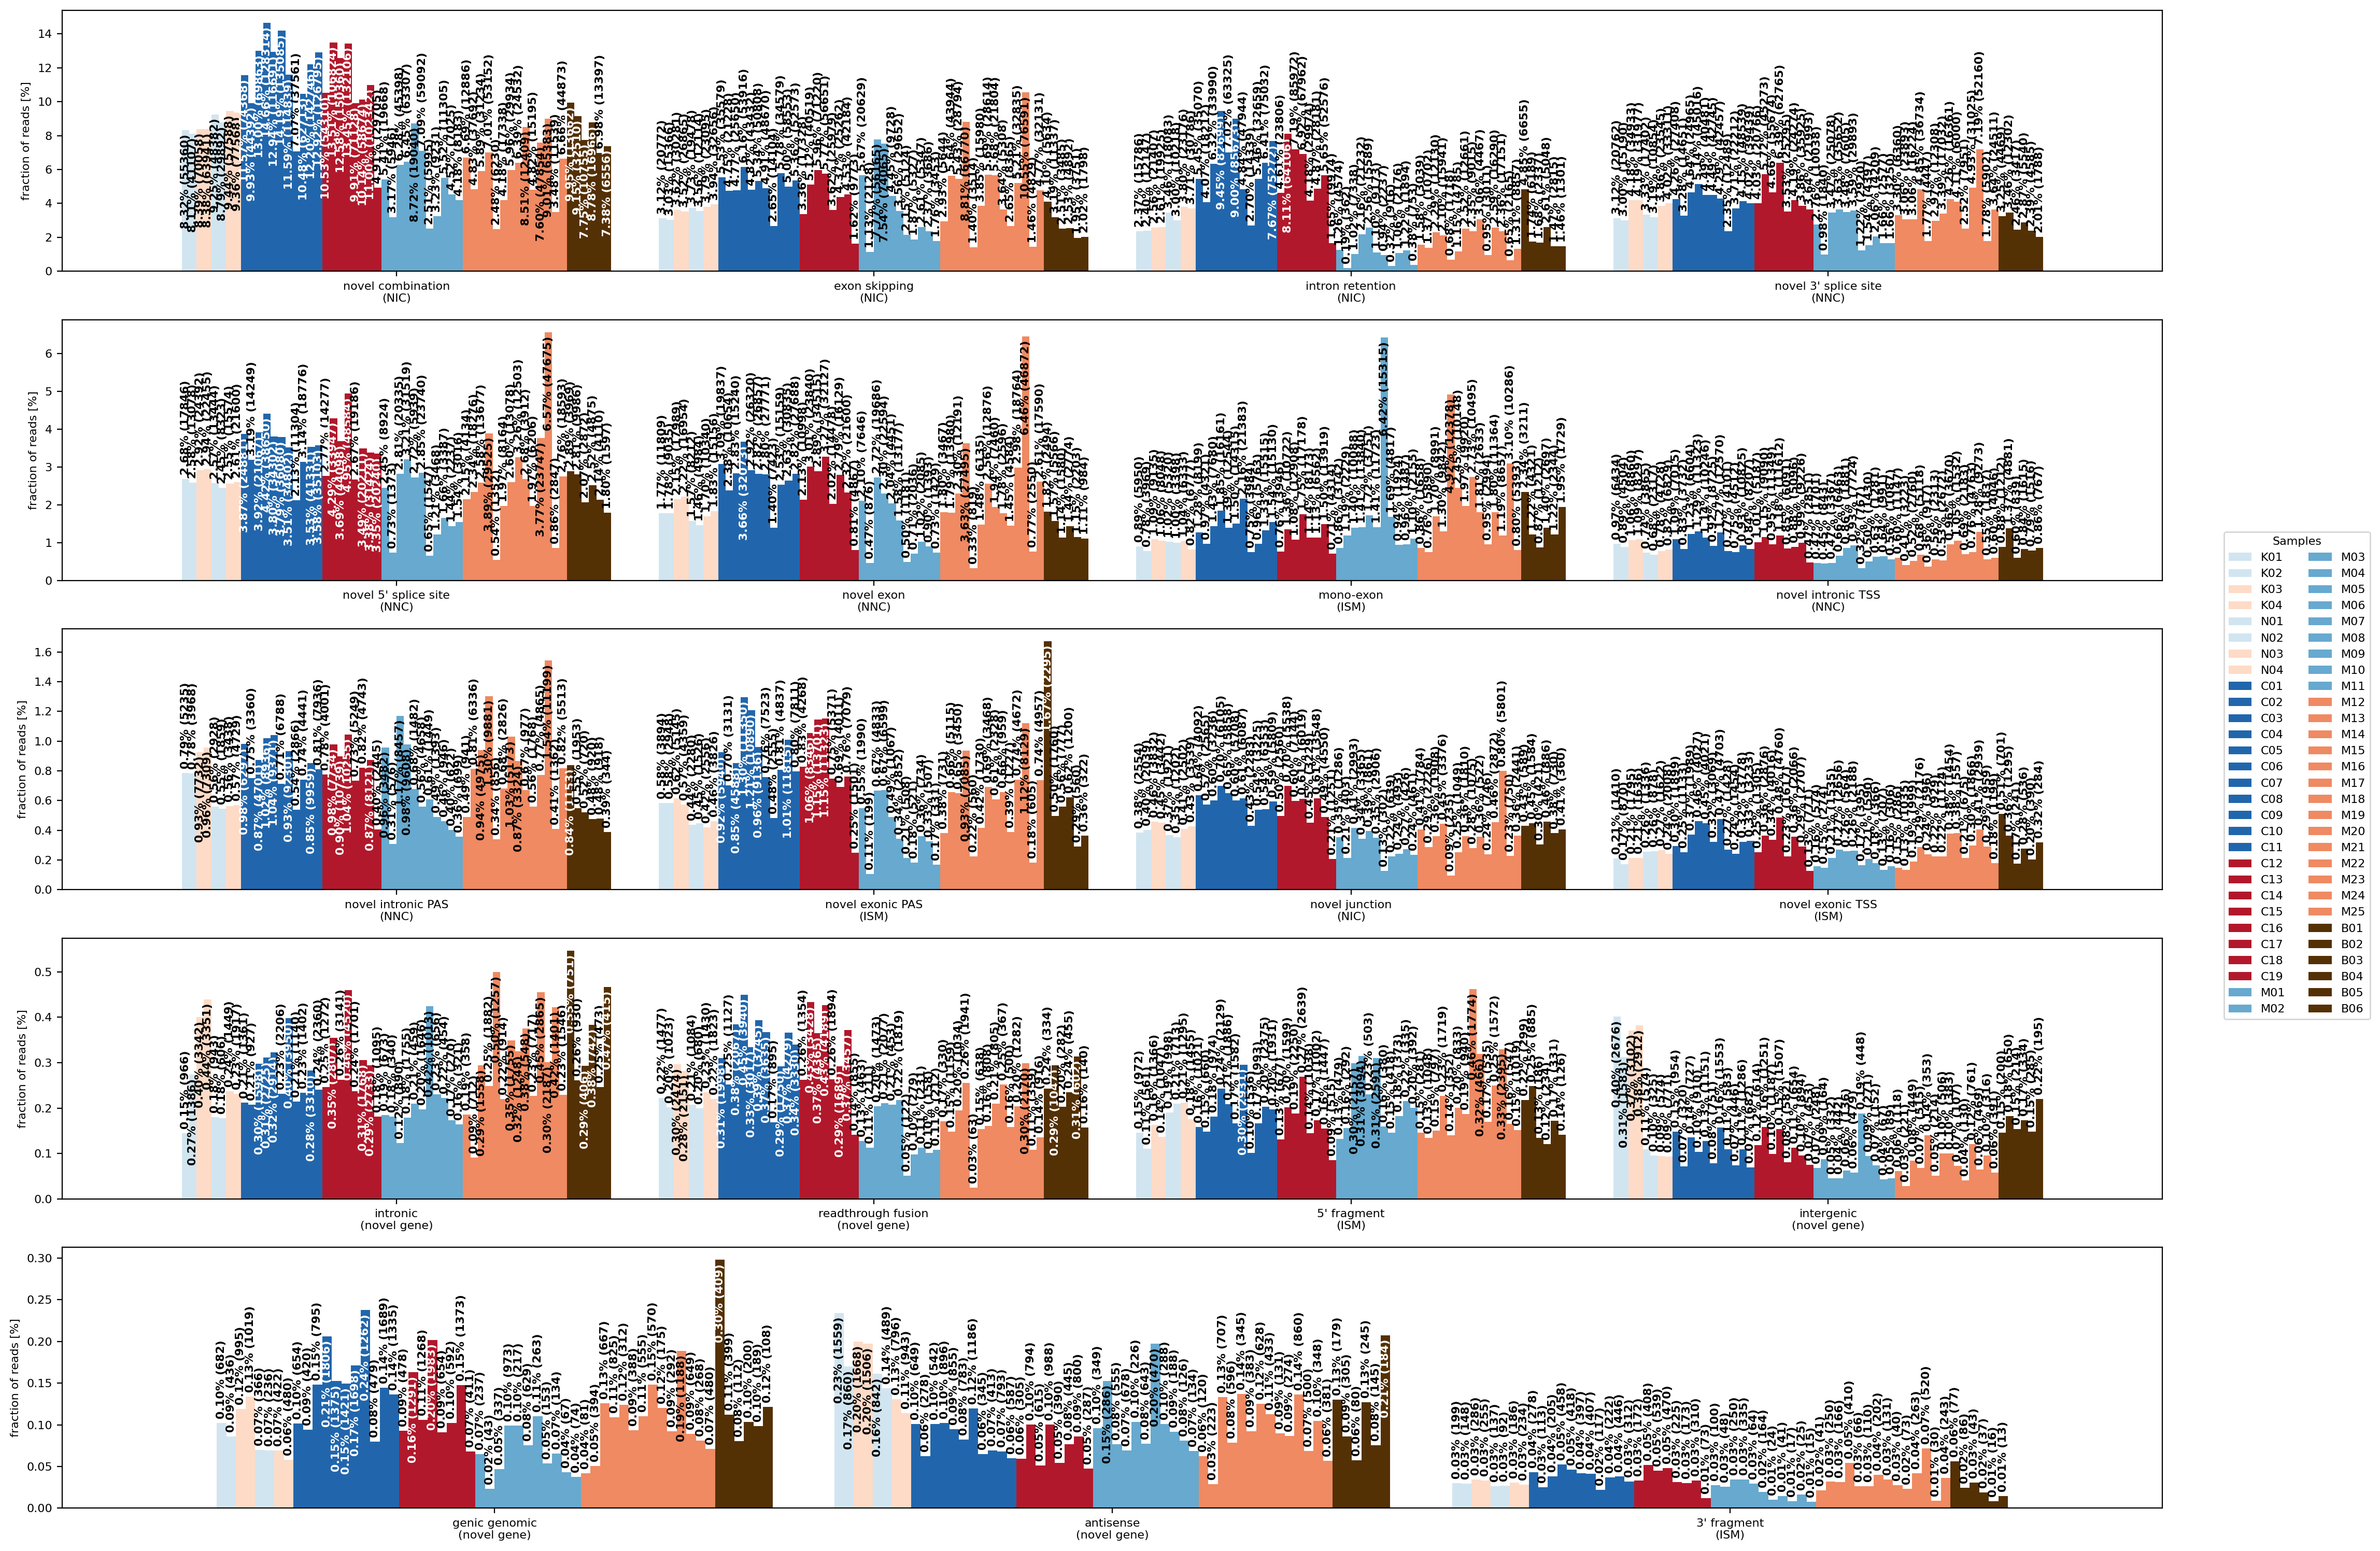

In [21]:
plt.rcParams["figure.figsize"] = (12,5)
fig, axs = plt.subplots( 2)
asidx=0 # SUBSTANTIAL
for i,ax in enumerate(axs):
    cat=altsplice[asidx][0].index[i*10+2:(i+1)*10+2]
    plot_bar(altsplice[asidx][0],bar_width=.9,ax=ax,ylabel=altsplice[asidx][1]['ylabel'], 
             legend=False, rot=0,drop_categories=[c for c in altsplice[asidx][0].index if c not in cat], colors=group_colors)  
axs[0].legend( ncol=10,handleheight=.4, labelspacing=0.05)

#plot_bar(altsplice[1][0],ax=axs[1],**altsplice[1][1])  
fig.tight_layout()
plt.savefig(f'{plot_path}/{project}_{date}_altsplice.pdf')
altsplice[0][0].to_csv(f'{table_path}/{project}_{date}_altsplice.csv')

plt.rcParams["figure.figsize"] = (21,15)
fig, axs = plt.subplots( 5)


for i,ax in enumerate(axs.flatten()):
    cat=altsplice_sample[0].index[i*4+2:(i+1)*4+2]
    plot_bar(altsplice_sample[0],bar_width=.9,ax=ax,ylabel='fraction of reads [%]', legend=False, rot=0,colors=sample_colors, drop_categories=[c for c in altsplice_sample[0].index if c not in cat])  
handles, labels = axs[0].get_legend_handles_labels()
fig.legend(handles,labels, title='Samples', bbox_to_anchor=(1.02, .5), loc='center left',ncol=2)

fig.tight_layout()
fig.savefig(f'{plot_path}/{project}_{date}_altsplice_sample.pdf', bbox_inches='tight')
altsplice_sample[0].to_csv(f'{table_path}/{project}_{date}_altsplice_sample.csv')
altsplice_sum=altsplice_sample[0].sum(1)
print(altsplice_sum/altsplice_sum.total)

In [22]:
# expect more fracmets for poor quality MDS samples
g=isoseq['SF3B1']
sa_idx={sa:i for i,sa in enumerate(isoseq.samples)}
fragment_ids=g.filter_transcripts("FRAGMENT")
for sa in isoseq.samples:
    nf=g.coverage[sa_idx[sa], fragment_ids].sum()
    nt=g.coverage[sa_idx[sa], :].sum()
    print(f'{sa} ({isoseq.sample_table.set_index("name").loc[sa, "TSM_ID"]}): {nf}/{nt} ({nf/nt:.2%})')


K01 (D001): 4/788 (0.51%)
K02 (D002): 7/824 (0.85%)
K03 (D003): 113/1557 (7.26%)
K04 (D004): 102/1299 (7.85%)
N01 (D005): 9/1270 (0.71%)
N02 (D006): 10/787 (1.27%)
N03 (D007): 140/1275 (10.98%)
N04 (D008): 218/2501 (8.72%)
C01 (25-10): 32/1454 (2.20%)
C02 (25-11): 26/1043 (2.49%)
C03 (25-12): 21/1350 (1.56%)
C04 (25-13): 44/2606 (1.69%)
C05 (25-14): 27/2749 (0.98%)
C06 (25-15): 43/3283 (1.31%)
C07 (25-17): 53/2457 (2.16%)
C08 (25-21): 35/820 (4.27%)
C09 (25-22): 37/1587 (2.33%)
C10 (25-23): 81/3310 (2.45%)
C11 (25-24): 39/2508 (1.56%)
C12 (25-9): 17/1360 (1.25%)
C13 (25-16): 38/3110 (1.22%)
C14 (25-18): 64/6938 (0.92%)
C15 (25-20): 67/3234 (2.07%)
C16 (25-25): 49/1635 (3.00%)
C17 (25-26): 29/1426 (2.03%)
C18 (25-27): 45/2297 (1.96%)
C19 (25-28): 14/359 (3.90%)
M01 (25-31): 15/249 (6.02%)
M02 (25-35): 12/12 (100.00%)
M03 (25-37): 33/293 (11.26%)
M04 (25-39): 32/760 (4.21%)
M05 (25-41): 11/218 (5.05%)
M06 (25-43): 23/512 (4.49%)
M07 (25-45): 10/13 (76.92%)
M08 (25-49): 19/20 (95.00%)
M09

In [23]:
sorted(enumerate(g.coverage[sa_idx["M16"],:]), key=lambda x:-x[1])[:5]

[(103, 5), (383, 3), (60, 2), (324, 1), (515, 1)]

In [24]:
383 in fragment_ids

True

In [25]:
g.transcripts[383]['exons']

[[197391983, 197392461],
 [197392971, 197393188],
 [197396055, 197396328],
 [197397984, 197398116],
 [197398460, 197398581],
 [197400054, 197400166]]

In [26]:
isoseq.filter['transcript']['FRAGMENT']

'fragments and any("novel exonic " in a or "fragment" in a for a in annotation[1])'

In [27]:
g.transcripts[383]['annotation']

(1, {"5' fragment": [[197400166, 197435028]]})